In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# sys.path.append("..")
# from config.config import Config

IMAGE_DIR = Path("/home/anawat/JJ/Chula/Chess2PGN/data")
FRAME_INTERVAL = 1 # seconds
IMAGE_SIZE = (512,512)
BILATERAL_FILTER_DIAMETER = 3
BILATERAL_FILTER_SIGMA_COLOR = 75
BILATERAL_FILTER_SIGMA_SPACE = 75

VIDEO_PATH = IMAGE_DIR / "video" / "4_Move_student.mp4"

def detect_board_roi(frame):
    """
    Automatically detect chess board region in frame
    
    Returns:
        (x, y, w, h) bounding box of board, or None if not found
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Apply threshold to find board (green/white squares are brighter than black bars)
    _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    # Find largest contour (should be the board)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    return (x, y, w, h)

def get_roi_from_first_frame(video_path):
    """
    Detect ROI from the first frame only
    
    Returns:
        (x, y, w, h) tuple or None
    """
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Read first frame
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        raise ValueError("Cannot read first frame")
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    print("Detecting board region from first frame...")
    roi = detect_board_roi(frame_rgb)
    
    if roi:
        x, y, w, h = roi
        print(f"✓ Board detected at: x={x}, y={y}, w={w}, h={h}")
        print(f"  Size: {w}x{h}, Aspect ratio: {w/h:.2f}")
    else:
        print("✗ Warning: Could not detect board")
    
    return roi, frame_rgb

def extract_frames_from_video(video_path, roi, interval_seconds=2):
    """
    Extract frames from video using pre-detected ROI
    
    Args:
        video_path: Path to video file
        roi: (x, y, w, h) tuple for cropping
        interval_seconds: Time interval between extracted frames
        
    Returns:
        List of frame dictionaries
    """
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    
    print(f"\nVideo info:")
    print(f"  FPS: {fps:.2f}")
    print(f"  Total frames: {total_frames}")
    print(f"  Duration: {duration:.2f} seconds")
    print(f"  Extracting frames every {interval_seconds} seconds...")
    
    frames = []
    frame_interval = int(fps * interval_seconds)
    frame_number = 0
    
    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        
        if not ret:
            break
        
        timestamp = frame_number / fps
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Crop to ROI if provided
        if roi:
            x, y, w, h = roi
            frame_cropped = frame_rgb[y:y+h, x:x+w]
        else:
            frame_cropped = frame_rgb
        
        # Resize to standard size
        frame_resized = cv2.resize(frame_cropped, IMAGE_SIZE, 
                                   interpolation=cv2.INTER_LINEAR)
        
        frames.append({
            'frame': frame_resized,
            'frame_original': frame_rgb,  # Keep original for debugging
            'timestamp': timestamp,
            'frame_number': frame_number,
            'roi': roi
        })
        
        # print(f"  ✓ Frame at {timestamp:.2f}s (frame {frame_number})")
        
        frame_number += frame_interval
    
    cap.release()
    print(f"\nTotal frames extracted: {len(frames)}")
    
    return frames

roi, first_frame = get_roi_from_first_frame(VIDEO_PATH)

frames = extract_frames_from_video(VIDEO_PATH, roi, FRAME_INTERVAL)

# Visualize extracted frames
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frame_data in enumerate(frames[:6]):
    if i < len(axes):
        axes[i].imshow(frame_data['frame'])
        axes[i].set_title(f"t={frame_data['timestamp']:.1f}s")
        axes[i].axis('off')

for i in range(len(frames[:6]), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Summary:")
print(f"  ROI detected once: {'Yes' if roi else 'No'}")
print(f"  Frames extracted: {len(frames)}")
print(f"  Frame size: {IMAGE_SIZE}")
print(f"{'='*60}")

Detecting board region from first frame...
✓ Board detected at: x=1, y=428, w=1079, h=1064
  Size: 1079x1064, Aspect ratio: 1.01

Video info:
  FPS: 29.98
  Total frames: 3248
  Duration: 108.35 seconds
  Extracting frames every 1 seconds...


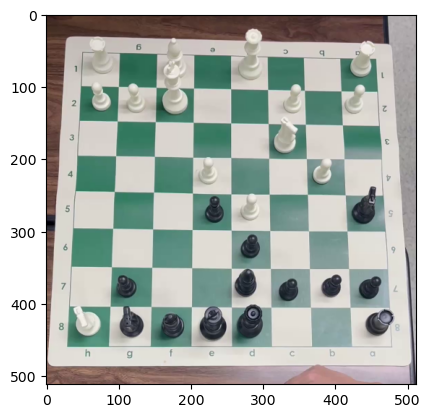

In [ ]:
img = frames[0]['frame']

plt.imshow(img)

In [ ]:
def cannyPF(img, sigma=0.25):
    med = np.median(img)
    lower = int(max(0, (1.0 - sigma) * med))
    upper = int(min(255, (1.0 + sigma) * med))
    return cv2.Canny(img, lower, upper)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bilateral = cv2.bilateralFilter(gray, d=(BILATERAL_FILTER_DIAMETER), sigmaColor=75, sigmaSpace=75)

canny = cannyPF(bilateral, sigma=0.33)

lines = cv2.HoughLines(canny, 1, np.pi/720.0, 50, np.array([]), 0, 0)
lines_best = np.squeeze(lines)[:100]

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalize features (rho and theta have different scales)
scaler = StandardScaler()
lines_normalized = scaler.fit_transform(lines_best)

# Cluster similar lines
clustering = DBSCAN(eps=0.05, min_samples=2).fit(lines_normalized)
labels = clustering.labels_

# Average lines within each cluster
unique_lines = []
for label in set(labels):
    if label != -1:  # Not noise
        cluster_lines = lines_best[labels == label]
        avg_rho = np.mean(cluster_lines[:, 0])
        avg_theta = np.mean(cluster_lines[:, 1])
        unique_lines.append([avg_rho, avg_theta])

In [ ]:
group1, group2 = [], []
temp_group = []
group1_mean, group2_mean = None, None

for i, (rho, theta) in enumerate(unique_lines):
  if group1_mean is None:
    if theta >=np.pi/3 and theta <= 2*np.pi/3:
      group1.append(i)
      group1_mean = theta
    else:
      temp_group.append(i)
  else:
    diff = abs(theta - group1_mean) 
    if diff <= np.pi/3:
      group1.append(i)
      group1_mean = np.mean([unique_lines[j][1] for j in group1])
    else:
      temp_group.append(i)

for i in temp_group:
  rho, theta = unique_lines[i]
  diff = abs(theta - group1_mean)
  if diff > np.pi/3:
    group2.append(i)
    if group2_mean is None:
      group2_mean = theta
    else:
      group2_mean = np.mean([unique_lines[j][1] for j in group2])
  else:
    group1.append(i)
    group1_mean = np.mean([unique_lines[j][1] for j in group1])

In [ ]:
import itertools

def select_best_9_lines(group_indices, unique_lines):
    """Select 9 lines with most uniform spacing"""
    
    # Extract lines and sort by rho (handle negative rho)
    lines_with_idx = [(i, unique_lines[i][0], unique_lines[i][1]) for i in group_indices]
    
    # Normalize: if rho < 0, flip to positive and adjust theta
    normalized = []
    for idx, rho, theta in lines_with_idx:
        if rho < 0:
            rho = -rho
            theta = theta + np.pi if theta < np.pi else theta - np.pi
        normalized.append((idx, rho, theta))
    
    # Sort by rho
    normalized.sort(key=lambda x: x[1])
    sorted_indices = [x[0] for x in normalized]
    sorted_rhos = [x[1] for x in normalized]
    
    if len(sorted_indices) <= 9:
        return sorted_indices
    
    # Try all combinations
    best_indices = None
    best_score = float('inf')
    
    for combo in itertools.combinations(range(len(sorted_indices)), 9):
        combo_rhos = [sorted_rhos[i] for i in combo]
        
        # Linear fit
        x = np.arange(9)
        poly_coeffs = np.polyfit(x, combo_rhos, deg=2)
        predicted = np.polyval(poly_coeffs, x)
        mse = np.mean((combo_rhos - predicted) ** 2)
        
        if mse < best_score:
            best_score = mse
            best_indices = [sorted_indices[i] for i in combo]
    
    return best_indices

# Select best 9 lines from each group
print("Selecting best 9 lines from Group 1...")
best_group1 = select_best_9_lines(group1, unique_lines)
print("Selecting best 9 lines from Group 2...")
best_group2 = select_best_9_lines(group2, unique_lines)

print(f"\nGroup 1: Selected {len(best_group1)} lines")
print(f"Group 2: Selected {len(best_group2)} lines")

Selecting best 9 lines from Group 1...
Selecting best 9 lines from Group 2...

Group 1: Selected 9 lines
Group 2: Selected 9 lines


Creating chess grid from detected lines...
Calculating cell centers...


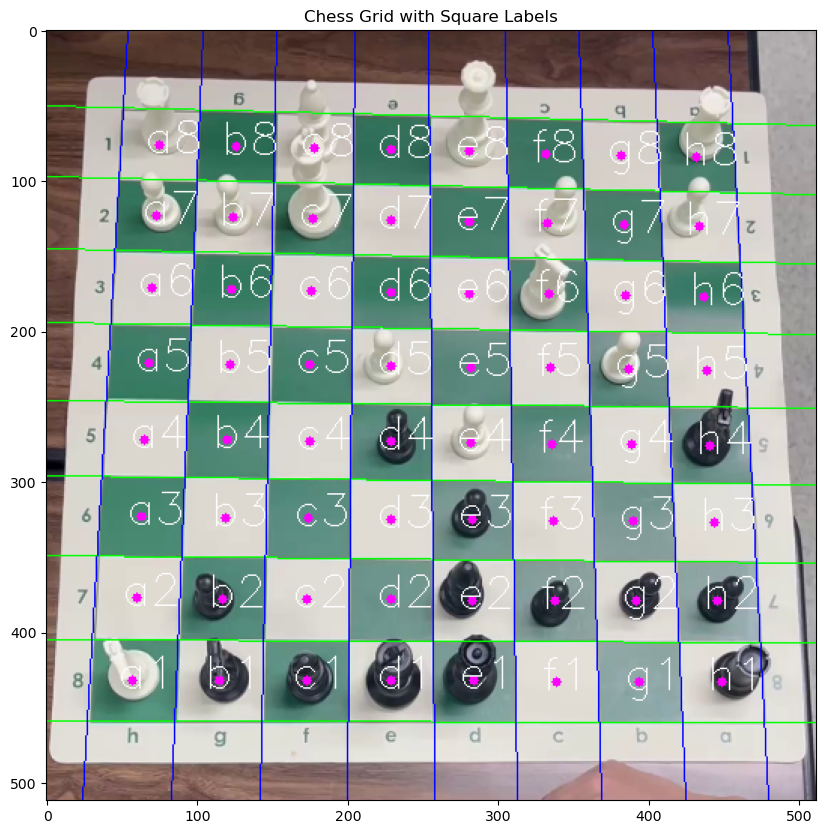


Grid created with 64 squares

Sample cell centers:
  a8: (75.4, 76.0)
  a1: (58.0, 432.5)
  h8: (432.8, 84.4)
  h1: (449.2, 433.2)


In [ ]:
def get_line_intersections(lines_group1, lines_group2, unique_lines, img_shape):
    """Calculate intersection points between two groups of lines"""
    intersections = []
    
    for i in lines_group1:
        rho1, theta1 = unique_lines[i]
        for j in lines_group2:
            rho2, theta2 = unique_lines[j]
            
            # Calculate intersection using Cramer's rule
            # Line 1: x*cos(theta1) + y*sin(theta1) = rho1
            # Line 2: x*cos(theta2) + y*sin(theta2) = rho2
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:  # Lines not parallel
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                
                # Check if intersection is within image bounds
                if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:
                    intersections.append((x, y))
    
    return intersections

def create_chess_grid(lines_group1, lines_group2, unique_lines, img_shape):
    """Create 8x8 chess grid from 9x9 line intersections"""
    
    # Sort lines by rho to get consistent ordering
    def get_sorted_lines(group_indices):
        lines_data = []
        for i in group_indices:
            rho, theta = unique_lines[i]
            if rho < 0:
                rho = -rho
                theta = theta + np.pi if theta < np.pi else theta - np.pi
            lines_data.append((i, rho, theta))
        lines_data.sort(key=lambda x: x[1])
        return [x[0] for x in lines_data]
    
    sorted_group1 = get_sorted_lines(lines_group1)
    sorted_group2 = get_sorted_lines(lines_group2)
    
    # Calculate all intersection points in order
    grid_points = np.zeros((9, 9, 2))
    
    for i, idx1 in enumerate(sorted_group1):
        for j, idx2 in enumerate(sorted_group2):
            rho1, theta1 = unique_lines[idx1]
            rho2, theta2 = unique_lines[idx2]
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                grid_points[i, j] = [x, y]
    
    return grid_points, sorted_group1, sorted_group2

def get_cell_centers(grid_points):
    """Calculate center points of 64 chess squares"""
    cell_centers = {}
    files = 'abcdefgh'
    ranks = '87654321'  # Top to bottom in image
    
    for row in range(8):
        for col in range(8):
            # Get 4 corners of the cell
            tl = grid_points[row, col]
            tr = grid_points[row, col + 1]
            bl = grid_points[row + 1, col]
            br = grid_points[row + 1, col + 1]
            
            # Calculate center
            center_x = (tl[0] + tr[0] + bl[0] + br[0]) / 4
            center_y = (tl[1] + tr[1] + bl[1] + br[1]) / 4
            
            # Map to chess notation
            square = files[col] + ranks[row]
            cell_centers[square] = {
                'center': (center_x, center_y),
                'corners': [tl, tr, br, bl]  # clockwise from top-left
            }
    
    return cell_centers

def point_in_cell(point, cell_data):
    """Check if a point is inside a cell using its corners"""
    px, py = point
    corners = cell_data['corners']
    
    # Use simple bounding box check (can be improved with polygon test)
    xs = [c[0] for c in corners]
    ys = [c[1] for c in corners]
    
    return min(xs) <= px <= max(xs) and min(ys) <= py <= max(ys)

def map_pieces_to_grid(yolo_results, cell_centers):
    """Map detected pieces to chess squares using bottom-center of bounding box"""
    board = {square: None for square in cell_centers.keys()}
    
    for box in yolo_results[0].boxes:
        # Get bounding box info
        x_center = float(box.xywh[0][0])
        y_center = float(box.xywh[0][1])
        width = float(box.xywh[0][2])
        height = float(box.xywh[0][3])
        
        # Calculate BOTTOM CENTER of bounding box (where piece actually sits)
        x_bottom_center = x_center
        y_bottom_center = y_center + (height / 2)
        
        class_id = int(box.cls[0])
        class_name = yolo_results[0].names[class_id]
        confidence = float(box.conf[0])
        
        # Find which square contains this piece
        for square, cell_data in cell_centers.items():
            if point_in_cell((x_bottom_center, y_bottom_center), cell_data):
                # Handle multiple detections: keep highest confidence
                if board[square] is not None:
                    print(f"Square {square} already has {board[square]['piece']} with confidence {board[square]['confidence']:.2f}. New piece: {class_name} with confidence {confidence:.2f}")
                if board[square] is None or confidence > board[square]['confidence']:
                    board[square] = {
                        'piece': class_name,
                        'confidence': confidence,
                        'position': (x_bottom_center, y_bottom_center),
                        'bbox_center': (x_center, y_center)  # Keep for visualization
                    }
                break
    
    return board

# Execute the pipeline
print("Creating chess grid from detected lines...")
grid_points, sorted_g1, sorted_g2 = create_chess_grid(
    best_group1, best_group2, unique_lines, img.shape
)

print("Calculating cell centers...")
cell_centers = get_cell_centers(grid_points)

# Visualize grid
canvas = img.copy()

# Draw grid lines
for i in sorted_g1:
    rho, theta = unique_lines[i]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 1)

for i in sorted_g2:
    rho, theta = unique_lines[i]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 1)

# Draw cell centers and labels
for square, cell_data in cell_centers.items():
    cx, cy = cell_data['center']
    cv2.circle(canvas, (int(cx), int(cy)), 3, (255, 0, 255), -1)
    cv2.putText(canvas, square, (int(cx)-10, int(cy)+5), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.title('Chess Grid with Square Labels')
plt.show()

print(f"\nGrid created with {len(cell_centers)} squares")
print("\nSample cell centers:")
for square in ['a8', 'a1', 'h8', 'h1']:
    center = cell_centers[square]['center']
    print(f"  {square}: ({center[0]:.1f}, {center[1]:.1f})")

In [ ]:
def filter_and_group_stable_frames(frames, change_threshold=0.05):
    """
    Filter frames using progressive baseline comparison and group consecutive valid frames.
    Consecutive valid frames are considered as the same board state.
    
    Args:
        frames: List of frame dictionaries with 'frame' key
        change_threshold: Maximum allowed change percentage (0.05 = 5%)
        
    Returns:
        List of grouped states, each containing representative frame and all frames in that state
    """
    if len(frames) == 0:
        return []
    
    # Helper function to calculate frame difference
    def calculate_difference(frame1, frame2):
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        diff = cv2.absdiff(gray1, gray2)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        changed_pixels = np.count_nonzero(thresh)
        return changed_pixels / thresh.size
    
    baseline_frame = frames[0]['frame']
    valid_frames = []
    
    print(f"\nFiltering frames (threshold: {change_threshold*100:.1f}% change)...")
    print("="*70)
    
    # Step 1: Filter valid frames
    for i, frame_data in enumerate(frames):
        current_frame = frame_data['frame']
        timestamp = frame_data['timestamp']
        
        diff_percentage = calculate_difference(baseline_frame, current_frame)
        
        if diff_percentage <= change_threshold:
            status = "✓ VALID"
            valid_frames.append({
                **frame_data,
                'diff_from_baseline': diff_percentage,
                'original_index': i
            })
            baseline_frame = current_frame
            baseline_info = "(new baseline)"
        else:
            status = "✗ REJECTED"
            baseline_info = "(too much change)"
        
        print(f"Frame {i:2d} | t={timestamp:5.1f}s | "
              f"Change: {diff_percentage*100:5.2f}% | {status} {baseline_info}")
    
    print("="*70)
    print(f"Valid frames: {len(valid_frames)}/{len(frames)}\n")
    
    # Step 2: Group consecutive valid frames
    if len(valid_frames) == 0:
        return []
    
    grouped_states = []
    current_group = [valid_frames[0]]
    
    print("Grouping consecutive frames...")
    print("="*70)
    
    for i in range(1, len(valid_frames)):
        prev_idx = valid_frames[i-1]['original_index']
        curr_idx = valid_frames[i]['original_index']
        
        # Check if consecutive (no rejected frames between)
        if curr_idx == prev_idx + 1:
            # Same state - add to current group
            current_group.append(valid_frames[i])
            print(f"  Frame {curr_idx} → Added to current state (consecutive)")
        else:
            # New state - save previous group and start new one
            grouped_states.append({
                'representative_frame': current_group[0],  # Use first frame as representative
                'frames': current_group,
                'state_id': len(grouped_states),
                'frame_count': len(current_group),
                'time_start': current_group[0]['timestamp'],
                'time_end': current_group[-1]['timestamp'],
                'duration': current_group[-1]['timestamp'] - current_group[0]['timestamp']
            })
            print(f"  ✓ State {len(grouped_states)-1}: {len(current_group)} frames "
                  f"({current_group[0]['timestamp']:.1f}s - {current_group[-1]['timestamp']:.1f}s)")
            
            current_group = [valid_frames[i]]
            print(f"  Frame {curr_idx} → New state started")
    
    # Add last group
    grouped_states.append({
        'representative_frame': current_group[0],
        'frames': current_group,
        'state_id': len(grouped_states),
        'frame_count': len(current_group),
        'time_start': current_group[0]['timestamp'],
        'time_end': current_group[-1]['timestamp'],
        'duration': current_group[-1]['timestamp'] - current_group[0]['timestamp']
    })
    print(f"  ✓ State {len(grouped_states)-1}: {len(current_group)} frames "
          f"({current_group[0]['timestamp']:.1f}s - {current_group[-1]['timestamp']:.1f}s)")
    
    print("="*70)
    print(f"Result: {len(grouped_states)} distinct board states\n")
    
    return grouped_states

# Usage with 1 second interval
roi, first_frame = get_roi_from_first_frame(VIDEO_PATH)
frames = extract_frames_from_video(VIDEO_PATH, roi, interval_seconds=1)  # 1 second intervals

# Filter and group
board_states = filter_and_group_stable_frames(frames, change_threshold=0.05)

# Print summary
print("\n" + "="*70)
print("BOARD STATES SUMMARY")
print("="*70)
for state in board_states:
    print(f"State {state['state_id']}: "
          f"{state['frame_count']} frames | "
          f"{state['time_start']:.1f}s - {state['time_end']:.1f}s | "
          f"duration: {state['duration']:.1f}s")
print("="*70)

Detecting board region from first frame...
✓ Board detected at: x=1, y=428, w=1079, h=1064
  Size: 1079x1064, Aspect ratio: 1.01

Video info:
  FPS: 29.97
  Total frames: 1578
  Duration: 52.65 seconds
  Extracting frames every 1 seconds...

Total frames extracted: 55

Filtering frames (threshold: 5.0% change)...
Frame  0 | t=  0.0s | Change:  0.00% | ✓ VALID (new baseline)
Frame  1 | t=  1.0s | Change:  3.40% | ✓ VALID (new baseline)
Frame  2 | t=  1.9s | Change:  4.58% | ✓ VALID (new baseline)
Frame  3 | t=  2.9s | Change:  9.35% | ✗ REJECTED (too much change)
Frame  4 | t=  3.9s | Change:  9.65% | ✗ REJECTED (too much change)
Frame  5 | t=  4.8s | Change: 10.17% | ✗ REJECTED (too much change)
Frame  6 | t=  5.8s | Change: 27.76% | ✗ REJECTED (too much change)
Frame  7 | t=  6.8s | Change: 24.36% | ✗ REJECTED (too much change)
Frame  8 | t=  7.7s | Change: 21.70% | ✗ REJECTED (too much change)
Frame  9 | t=  8.7s | Change: 22.37% | ✗ REJECTED (too much change)
Frame 10 | t=  9.7s | C

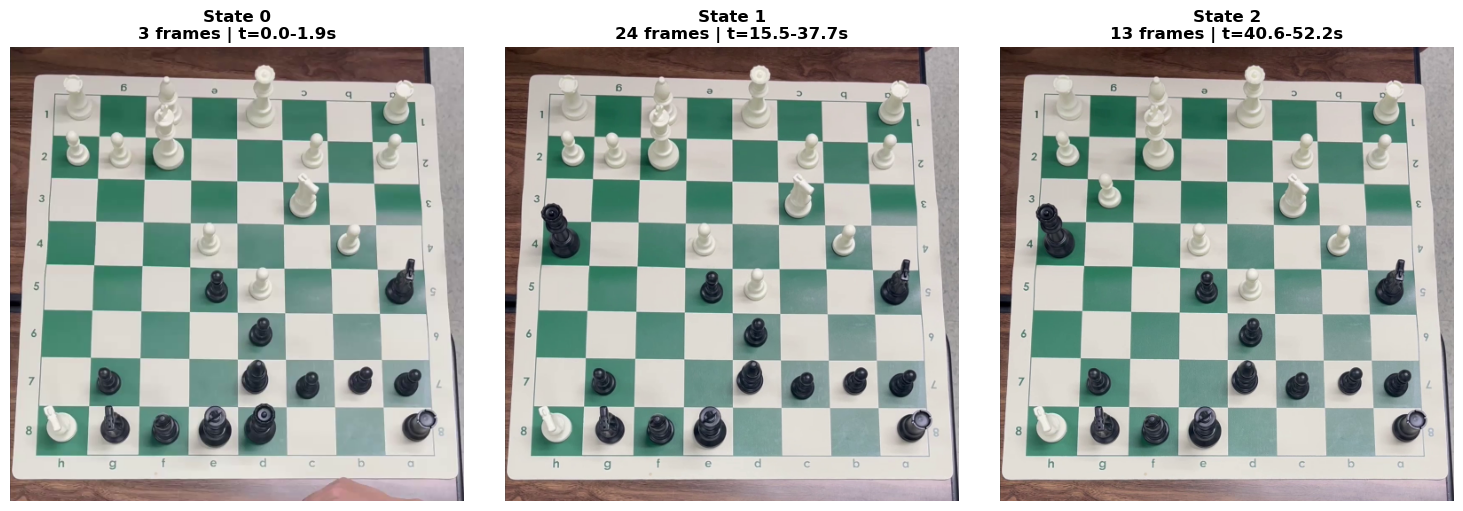

In [ ]:
# Visualize representative frame from each state
n_states = len(board_states)
n_cols = min(3, n_states)
n_rows = (n_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if n_states == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_states > 1 else [axes]

for i, state in enumerate(board_states):
    if i < len(axes):
        rep_frame = state['representative_frame']['frame']
        axes[i].imshow(rep_frame)
        axes[i].set_title(f"State {state['state_id']}\n"
                         f"{state['frame_count']} frames | "
                         f"t={state['time_start']:.1f}-{state['time_end']:.1f}s",
                         fontweight='bold', fontsize=12)
        axes[i].axis('off')

# Hide unused subplots
for i in range(n_states, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def get_consensus_board_state(state_frames, yolo_model, cell_centers, 
                               max_samples=5, confidence_threshold=0.7):
    """
    Get consensus board state from multiple frames using voting.
    
    Args:
        state_frames: List of frame dictionaries from a board state
        yolo_model: YOLO model for piece detection
        cell_centers: Chess grid cell centers
        max_samples: Maximum number of frames to sample (5-10 recommended)
        confidence_threshold: Minimum confidence to consider a detection
        
    Returns:
        Consensus board state with voting statistics
    """
    # Sample frames evenly if there are too many
    n_frames = len(state_frames)
    if n_frames > max_samples:
        # Sample evenly across the state duration
        indices = np.linspace(0, n_frames - 1, max_samples, dtype=int)
        sampled_frames = [state_frames[i] for i in indices]
        print(f"  Sampling {max_samples}/{n_frames} frames: {list(indices)}")
    else:
        sampled_frames = state_frames
        print(f"  Using all {n_frames} frames")
    
    # Collect votes for each square
    square_votes = {square: {} for square in cell_centers.keys()}
    
    # Run detection on each sampled frame
    for frame_idx, frame_data in enumerate(sampled_frames):
        frame = frame_data['frame']
        
        # YOLO detection
        results = yolo_model(frame, verbose=False)
        board = map_pieces_to_grid(results, cell_centers)
        
        # Count votes
        for square, piece_data in board.items():
            if piece_data is not None and piece_data['confidence'] >= confidence_threshold:
                piece_name = piece_data['piece']
                
                if piece_name not in square_votes[square]:
                    square_votes[square][piece_name] = {
                        'count': 0,
                        'confidences': []
                    }
                
                square_votes[square][piece_name]['count'] += 1
                square_votes[square][piece_name]['confidences'].append(piece_data['confidence'])
    
    # Determine consensus for each square
    consensus_board = {}
    total_frames = len(sampled_frames)
    
    for square, votes in square_votes.items():
        if len(votes) == 0:
            # No detections - empty square
            consensus_board[square] = None
        else:
            # Find piece with most votes
            best_piece = max(votes.items(), key=lambda x: x[1]['count'])
            piece_name = best_piece[0]
            vote_count = best_piece[1]['count']
            confidences = best_piece[1]['confidences']
            
            # Calculate statistics
            vote_percentage = vote_count / total_frames
            avg_confidence = np.mean(confidences)
            
            # Only accept if majority agrees (>50%) or high confidence (>0.85)
            if vote_percentage > 0.5 or avg_confidence > 0.85:
                consensus_board[square] = {
                    'piece': piece_name,
                    'confidence': avg_confidence,
                    'votes': f"{vote_count}/{total_frames}",
                    'vote_percentage': vote_percentage,
                    'all_votes': votes  # Keep for debugging
                }
            else:
                # Not enough consensus
                consensus_board[square] = None
    
    return consensus_board


def process_all_board_states(board_states, yolo_model, cell_centers, 
                             max_samples=5, confidence_threshold=0.7):
    """
    Process all board states to get consensus board positions.
    
    Args:
        board_states: List of grouped board states
        yolo_model: YOLO model
        cell_centers: Chess grid
        max_samples: Max frames to sample per state
        confidence_threshold: Min detection confidence
        
    Returns:
        List of states with consensus boards
    """
    processed_states = []
    
    print("\n" + "="*70)
    print("PROCESSING BOARD STATES WITH CONSENSUS")
    print("="*70)
    
    for state in board_states:
        state_id = state['state_id']
        frames = state['frames']
        
        print(f"\nState {state_id}: Processing {len(frames)} frames...")
        
        # Get consensus board
        consensus_board = get_consensus_board_state(
            frames, yolo_model, cell_centers, 
            max_samples=max_samples,
            confidence_threshold=confidence_threshold
        )
        
        # Count pieces
        piece_count = sum(1 for v in consensus_board.values() if v is not None)
        
        # Calculate average vote percentage
        vote_percentages = [v['vote_percentage'] for v in consensus_board.values() 
                           if v is not None]
        avg_vote_pct = np.mean(vote_percentages) if vote_percentages else 0
        
        print(f"  ✓ Detected {piece_count} pieces")
        print(f"  ✓ Average consensus: {avg_vote_pct*100:.1f}%")
        
        # Add consensus board to state
        processed_states.append({
            **state,
            'consensus_board': consensus_board,
            'piece_count': piece_count,
            'avg_consensus': avg_vote_pct
        })
    
    print("\n" + "="*70)
    print(f"Processed {len(processed_states)} states")
    print("="*70)
    
    return processed_states


# Usage
from ultralytics import YOLO

# Load YOLO model
model = YOLO("/home/anawat/JJ/Chula/Chess2PGN/weights/chess-piece/best(4).pt")

# Process all states with consensus
processed_states = process_all_board_states(
    board_states, 
    model, 
    cell_centers,
    max_samples=10,  # Sample at most 10 frames per state
    confidence_threshold=0.2  # Only trust detections >0.2
)

# Print results
print("\n" + "="*70)
print("CONSENSUS BOARD STATES")
print("="*70)
for state in processed_states:
    print(f"\nState {state['state_id']} ({state['time_start']:.1f}s - {state['time_end']:.1f}s)")
    print(f"  Pieces detected: {state['piece_count']}")
    print(f"  Average consensus: {state['avg_consensus']*100:.1f}%")
    
    # Show high-confidence pieces
    board = state['consensus_board']
    confident_pieces = {sq: data for sq, data in board.items() 
                       if data and data['vote_percentage'] > 0.8}
    print(f"  High confidence pieces (>80% votes): {len(confident_pieces)}")


PROCESSING BOARD STATES WITH CONSENSUS

State 0: Processing 3 frames...
  Using all 3 frames
Square e3 already has white-pawn with confidence 0.83. New piece: black-pawn with confidence 0.60
Square e1 already has black-queen with confidence 0.33. New piece: white-queen with confidence 0.31
Square d4 already has black-pawn with confidence 0.83. New piece: white-pawn with confidence 0.29
Square e2 already has white-bishop with confidence 0.50. New piece: black-bishop with confidence 0.25
  ✓ Detected 27 pieces
  ✓ Average consensus: 96.3%

State 1: Processing 24 frames...
  Sampling 10/24 frames: [np.int64(0), np.int64(2), np.int64(5), np.int64(7), np.int64(10), np.int64(12), np.int64(15), np.int64(17), np.int64(20), np.int64(23)]
Square h4 already has black-knight with confidence 0.82. New piece: white-knight with confidence 0.26
Square h4 already has black-knight with confidence 0.80. New piece: white-knight with confidence 0.26
Square h4 already has black-knight with confidence 0.87.

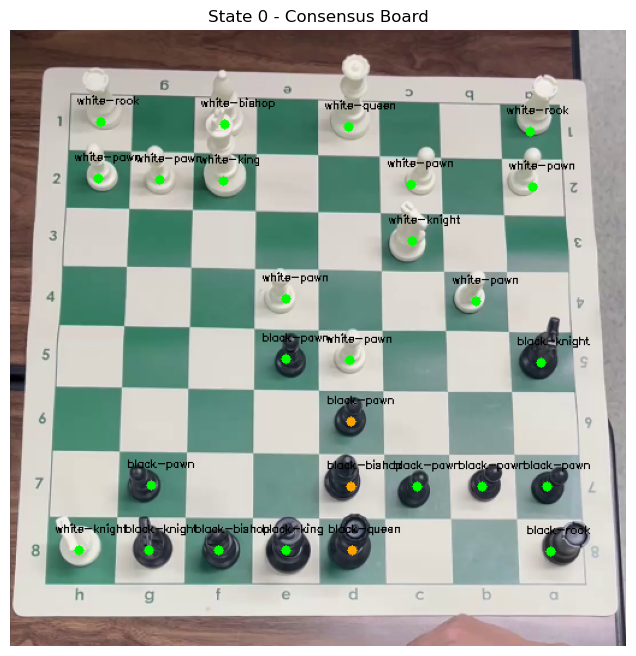

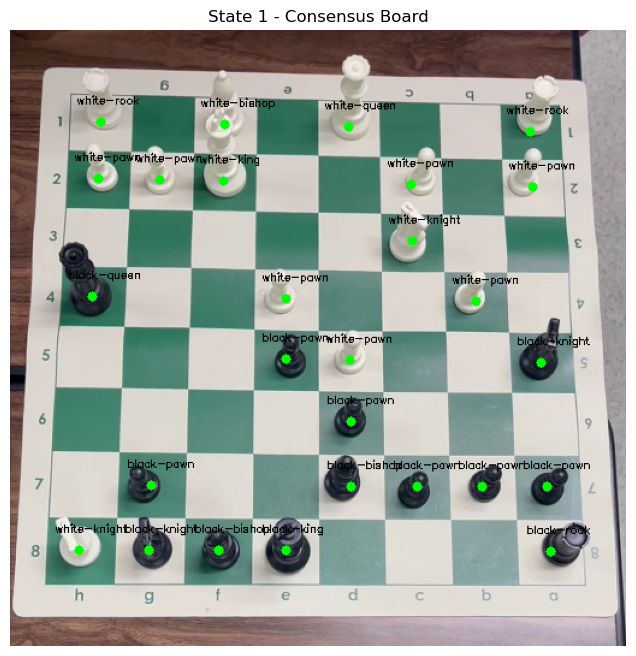

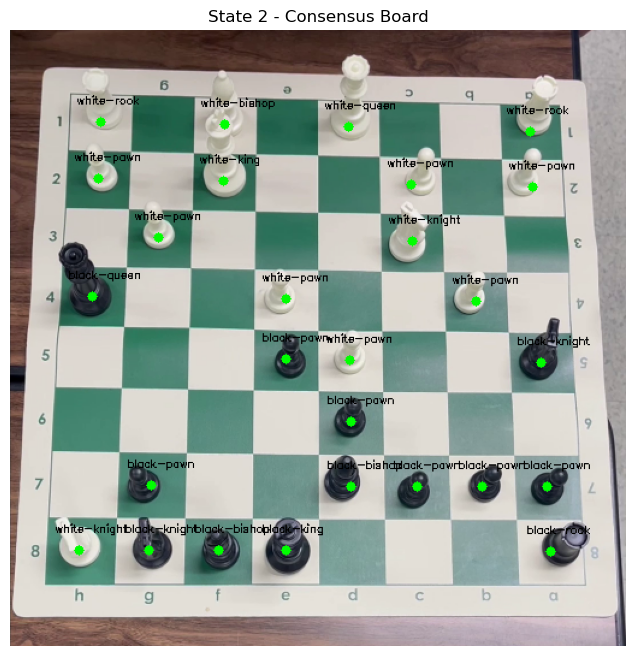

In [ ]:
def visualize_consensus_board(state, img_shape=(512, 512)):
    """Visualize consensus board state"""
    canvas = state['frames'][0]['frame'].copy()
    
    board = state['consensus_board']
    
    # Draw pieces with vote info
    for square, data in board.items():
        if data is not None:
            # Get square position (you'll need cell_centers)
            cx, cy = cell_centers[square]['center']
            
            piece = data['piece']
            votes = data['votes']
            conf = data['confidence']
            
            # Draw circle
            color = (0, 255, 0) if data['vote_percentage'] > 0.8 else (255, 165, 0)
            cv2.circle(canvas, (int(cx), int(cy)), 4, color, -1)
            
            # Draw label
            label = f"{piece}"
            cv2.putText(canvas, label, (int(cx)-20, int(cy)-15),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
    
    return canvas

# Visualize all states
for state in processed_states:
    vis = visualize_consensus_board(state)
    plt.figure(figsize=(8, 8))
    plt.imshow(vis)
    plt.title(f"State {state['state_id']} - Consensus Board")
    plt.axis('off')
    plt.show()

In [ ]:
def detect_move_by_diff(board_before, board_after):
    """
    Detect move by comparing two board states.
    
    Returns:
        dict with move information and confidence
    """
    disappeared = []  # Pieces that disappeared
    appeared = []     # New pieces that appeared
    changed = []      # Squares where piece changed
    
    all_squares = set(board_before.keys()) | set(board_after.keys())
    
    for square in all_squares:
        piece_before = board_before.get(square)
        piece_after = board_after.get(square)
        
        # Extract piece name (handle None)
        name_before = piece_before['piece'] if piece_before else None
        name_after = piece_after['piece'] if piece_after else None
        
        if name_before and not name_after:
            # Piece disappeared
            disappeared.append({
                'square': square,
                'piece': name_before,
                'confidence': piece_before['confidence']
            })
        elif not name_before and name_after:
            # Piece appeared
            appeared.append({
                'square': square,
                'piece': name_after,
                'confidence': piece_after['confidence']
            })
        elif name_before and name_after and name_before != name_after:
            # Piece changed (capture or promotion)
            changed.append({
                'square': square,
                'before': name_before,
                'after': name_after,
                'confidence_before': piece_before['confidence'],
                'confidence_after': piece_after['confidence']
            })
    
    return {
        'disappeared': disappeared,
        'appeared': appeared,
        'changed': changed
    }


def infer_move_notation(diff_result):
    """
    Infer chess move notation from diff results.
    
    Returns:
        Move string in simplified notation or None
    """
    disappeared = diff_result['disappeared']
    appeared = diff_result['appeared']
    changed = diff_result['changed']
    
    # Case 1: Normal move (1 disappeared, 1 appeared)
    if len(disappeared) == 1 and len(appeared) == 1 and len(changed) == 0:
        from_square = disappeared[0]['square']
        to_square = appeared[0]['square']
        piece = disappeared[0]['piece']
        
        # Calculate confidence (average of both detections)
        confidence = (disappeared[0]['confidence'] + appeared[0]['confidence']) / 2
        
        return {
            'notation': f"{piece}:{from_square}-{to_square}",
            'type': 'normal',
            'from': from_square,
            'to': to_square,
            'piece': piece,
            'confidence': confidence
        }
    
    # Case 2: Capture (2 disappeared, 1 appeared)
    elif len(disappeared) == 2 and len(appeared) == 1 and len(changed) == 0:
        # One piece moved, one was captured
        to_square = appeared[0]['square']
        
        # Find which piece moved (it appears at destination)
        moving_piece = appeared[0]['piece']
        
        # Find source square (piece that disappeared and matches moving piece)
        from_square = None
        for d in disappeared:
            if d['piece'] == moving_piece:
                from_square = d['square']
                break
        
        if from_square:
            confidence = (disappeared[0]['confidence'] + 
                         disappeared[1]['confidence'] + 
                         appeared[0]['confidence']) / 3
            
            return {
                'notation': f"{moving_piece}:{from_square}x{to_square}",
                'type': 'capture',
                'from': from_square,
                'to': to_square,
                'piece': moving_piece,
                'confidence': confidence
            }
    
    # Case 3: Castling (King + Rook move)
    elif len(disappeared) == 2 and len(appeared) == 2 and len(changed) == 0:
        # Check if it's castling
        kings = [d for d in disappeared if 'king' in d['piece'].lower()]
        rooks = [d for d in disappeared if 'rook' in d['piece'].lower()]
        
        if len(kings) == 1 and len(rooks) == 1:
            king_from = kings[0]['square']
            king_to = [a['square'] for a in appeared if 'king' in a['piece'].lower()][0]
            
            # Determine side
            if ord(king_to[0]) > ord(king_from[0]):
                castle_type = "O-O"  # Kingside
            else:
                castle_type = "O-O-O"  # Queenside
            
            confidence = np.mean([d['confidence'] for d in disappeared + appeared])
            
            return {
                'notation': castle_type,
                'type': 'castling',
                'confidence': confidence
            }
    
    # Case 4: Promotion (piece changes type on rank 8/1)
    elif len(changed) == 1 and len(disappeared) == 0 and len(appeared) == 0:
        square = changed[0]['square']
        before = changed[0]['before']
        after = changed[0]['after']
        
        # Check if pawn promoted
        if 'pawn' in before.lower() and square[1] in ['8', '1']:
            confidence = (changed[0]['confidence_before'] + 
                         changed[0]['confidence_after']) / 2
            
            return {
                'notation': f"{square}={after}",
                'type': 'promotion',
                'square': square,
                'promoted_to': after,
                'confidence': confidence
            }
    
    # Unknown/complex move
    return {
        'notation': f"???({len(disappeared)}d,{len(appeared)}a,{len(changed)}c)",
        'type': 'unknown',
        'confidence': 0.0,
        'details': diff_result
    }

def format_as_pgn(moves, starting_color='white'):
    """
    Format moves as PGN string in standard notation.
    
    Args:
        moves: List of move dictionaries
        starting_color: 'white' or 'black' - who moves first
        
    Returns:
        PGN string
    """
    pgn_moves = []
    
    # Determine starting move number and offset
    if starting_color == 'black':
        # Black starts: "1. ... e5 2. Nf3 ..."
        move_offset = 0
        pgn_moves.append("1. ...")
    else:
        move_offset = 0
    
    for i, move in enumerate(moves):
        notation = move['notation']
        
        # Convert to standard notation (remove piece prefix)
        # From: "white-pawn:e2-e4" or "black-knight:g8-f6"
        # To: "e4" or "Nf6"
        notation = convert_to_standard_notation(notation)
        
        # Add check symbol if needed
        # (You'll need to implement check detection)
        # notation = add_check_symbol(notation, move, board_state)
        
        # Add confidence marker for low-confidence moves
        if move['confidence'] < 0.5:
            notation += "{?}"
        
        # Calculate move number
        if starting_color == 'white':
            move_num = i // 2 + 1
            if i % 2 == 0:  # White's move
                pgn_moves.append(f"{move_num}. {notation}")
            else:  # Black's move
                pgn_moves[-1] += f" {notation}"
        else:  # Black starts first
            move_num = (i + 1) // 2 + 1
            if i % 2 == 0:  # Black's move (first mover)
                if i == 0:
                    pgn_moves[-1] += f" {notation}"
                else:
                    pgn_moves.append(f"{move_num}. ... {notation}")
            else:  # White's move
                pgn_moves[-1] += f" {notation}" if i > 0 else f"{move_num}. {notation}"
    
    return " ".join(pgn_moves)


def convert_to_standard_notation(notation):
    """
    Convert custom notation to standard PGN notation.
    
    Examples:
        "white-pawn:e2-e4" -> "e4"
        "black-knight:g8-f6" -> "Nf6"
        "white-bishop:f1xc4" -> "Bxc4"
        "O-O" -> "O-O" (already standard)
    """
    # Handle castling
    if notation.startswith("O-O"):
        return notation
    
    # Handle promotion
    if "=" in notation:
        # "e8=Q" is already standard
        return notation.split(":")[-1] if ":" in notation else notation
    
    # Handle unknown moves
    if notation.startswith("???"):
        return notation
    
    # Parse notation: "white-pawn:e2-e4" or "white-knight:b1xc3"
    if ":" not in notation:
        return notation
    
    piece_part, move_part = notation.split(":", 1)
    
    # Extract piece type
    piece_type = piece_part.split("-")[-1].lower()
    
    # Map piece types to standard notation
    piece_symbols = {
        'pawn': '',
        'knight': 'N',
        'bishop': 'B',
        'rook': 'R',
        'queen': 'Q',
        'king': 'K'
    }
    
    piece_symbol = piece_symbols.get(piece_type, '')
    
    # Parse move (e2-e4 or e2xe4)
    if 'x' in move_part:
        # Capture: e2xe4 -> exe4 or Nf3xd4 -> Nxd4
        from_sq, to_sq = move_part.split('x')
        if piece_type == 'pawn':
            # Pawn captures: include file
            result = f"{from_sq[0]}x{to_sq}"
        else:
            result = f"{piece_symbol}x{to_sq}"
    else:
        # Normal move: e2-e4 -> e4 or Nf3-d4 -> Nd4
        from_sq, to_sq = move_part.split('-')
        if piece_type == 'pawn':
            result = to_sq
        else:
            result = f"{piece_symbol}{to_sq}"
    
    return result


def detect_check(board_after, move):
    """
    Detect if the move resulted in check.
    (Simple heuristic - can be improved)
    
    Returns:
        True if opponent king is in check
    """
    # TODO: Implement check detection
    # This requires knowing which pieces can attack the opponent's king
    # For now, return False (no check detection)
    return False


def add_check_symbol(notation, move, board_after):
    """
    Add '+' symbol if move results in check.
    
    Args:
        notation: Current move notation
        move: Move dictionary
        board_after: Board state after the move
        
    Returns:
        Notation with '+' appended if check
    """
    if detect_check(board_after, move):
        return notation + "+"
    return notation


def generate_move_list_with_check(processed_states):
    """
    Generate move list with check detection.
    
    Returns:
        List of moves with metadata
    """
    moves = []
    
    print("\n" + "="*70)
    print("GENERATING MOVE LIST")
    print("="*70)
    
    for i in range(len(processed_states) - 1):
        state_before = processed_states[i]
        state_after = processed_states[i + 1]
        
        board_before = state_before['consensus_board']
        board_after = state_after['consensus_board']
        
        # Detect differences
        diff = detect_move_by_diff(board_before, board_after)
        
        # Infer move
        move = infer_move_notation(diff)
        move['move_number'] = i + 1
        move['time'] = f"{state_before['time_start']:.1f}s → {state_after['time_start']:.1f}s"
        
        # Check for check
        move['is_check'] = detect_check(board_after, move)
        
        moves.append(move)
        
        # Print move
        status = "✓" if move['confidence'] > 0.5 else "⚠"
        check_marker = "+" if move['is_check'] else ""
        print(f"Move {i+1}: {move['notation']}{check_marker} "
              f"[{move['type']}] "
              f"confidence: {move['confidence']:.2f} {status}")
    
    print("="*70)
    print(f"Total moves detected: {len(moves)}")
    print(f"Uncertain moves: {sum(1 for m in moves if m['confidence'] < 0.5)}")
    print("="*70)
    
    return moves


# Updated usage
moves = generate_move_list_with_check(processed_states)

# Detect starting color (white or black)
starting_color = moves[0]['notation'].split('-')[0].lower()

pgn = format_as_pgn(moves, starting_color=starting_color)

print("\n" + "="*70)
print("FINAL PGN")
print("="*70)
print(pgn)
print("="*70)


GENERATING MOVE LIST
Move 1: black-queen:e1-a5 [normal] confidence: 0.62 ✓
Move 2: white-pawn:b7-b6 [normal] confidence: 0.90 ✓
Total moves detected: 2
Uncertain moves: 0

FINAL PGN
1. Qa5 b6
